
Deep Learning HW2- part 2

BY: Dema Omar , Aya Fodi


# Part 2: Weather Classification

In this part, we build a **deep learning model** to classify different weather conditions from images.  
This task demonstrates the use of **powerful pretrained architectures** for real-world image recognition problems such as automated weather monitoring and disaster response.

The dataset contains images of **four weather classes**:
- **Sunrise**
- **Shine**
- **Cloudy**
- **Rain**

We will:
1. **Download and preprocess** the dataset.
2. **Visualize** a few samples from each class.  
3. **Load a pretrained model** from PyTorch (e.g., ResNet, VGG, or MobileNet) and fine tune it for 4 class classification.  
4. **Implement a custom loss function** (`MyLossFunction`) from scratch , no built in PyTorch loss functions allowed.  
5. **Train** the model and plot training/validation loss and accuracy curves.  
6. **Evaluate** the model on the test set by showing:
   - A few sample predictions with their true labels.  
   - Overall **test accuracy**.  
   - A **confusion matrix** of results.  
7. Apply **regularization techniques** to improve generalization.  
8. Use a **2D projection algorithm** (such as PCA or t-SNE) to visualize how the model separates weather classes in feature space.

The objective is to fine tune a pretrained network for maximum accuracy and demonstrate understanding of custom loss functions, evaluation metrics, and visualization of learned representations.


Download the train and test datasets from the website.
Preprocess it and showing a couple of images from
each of the classes with it’s corresponding label:

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


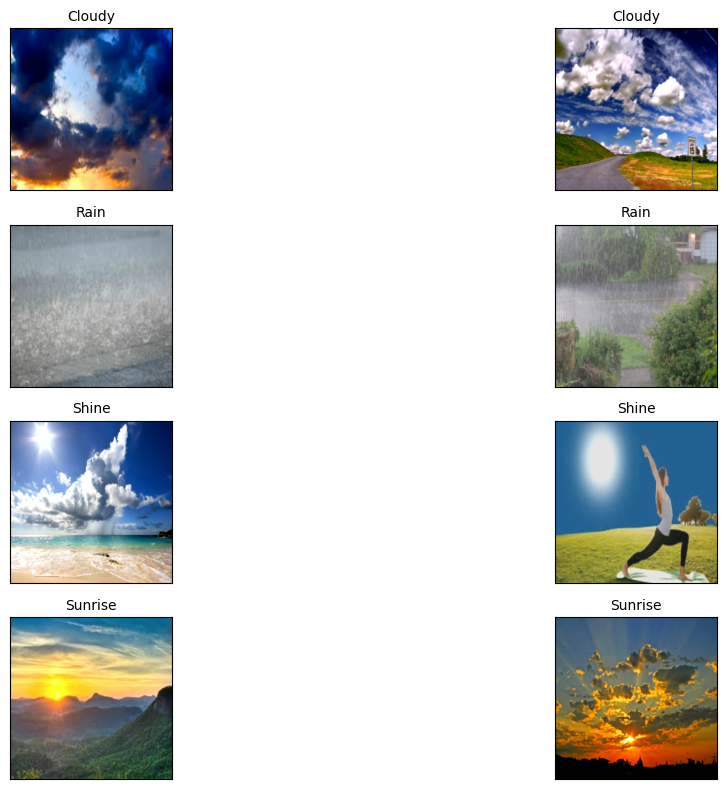

In [ ]:
import torchvision
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from google.colab import drive


drive.mount('/content/drive')

# Define data paths
data_dir = '/content/drive/My Drive/WeatherData/Data'
test_dir = '/content/drive/My Drive/WeatherData/Test'

# Data transformations for training and testing datasets
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load train dataset using ImageFolder
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.image_paths = [os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith(('jpg'))]
        self.class_names = ['cloudy','rain', 'shine', 'sunrise']

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # Extract label from filename prefix
        label = None
        for class_index, class_name in enumerate(self.class_names):
            if os.path.basename(img_path).lower().startswith(class_name):
                label = class_index
                break

        if label is None:
            raise ValueError(f"Label not found in filename: {os.path.basename(img_path)}")

        if self.transform:
            image = self.transform(image)

        return image, label  # Return image and label


test_dataset = TestDataset(test_dir, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to showcase a couple of images from each class
def showcase_images(dataset, class_names, num_images=2):

    fig = plt.figure(figsize=(15, len(class_names) * 2))  # Adjust figure size
    class_indices = {cls: [] for cls in range(len(class_names))}

    # Collect indices for each class
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    # Display images
    img_idx = 1
    for cls, indices in class_indices.items():
        selected_indices = random.sample(indices, min(num_images, len(indices)))
        for idx in selected_indices:
            image, label = dataset[idx]
            # De-normalize the image for display
            image = image.permute(1, 2, 0).numpy()  # Change CHW to HWC format
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)

            # Plot the image
            ax = fig.add_subplot(len(class_names), num_images, img_idx, xticks=[], yticks=[])
            ax.imshow(image)
            ax.set_title(f"{class_names[label]}", fontsize=10)
            img_idx += 1

    plt.tight_layout()
    plt.show()

# Call the function to showcase a couple of images per class from the train dataset
showcase_images(train_dataset, train_dataset.classes, num_images=2)

Here the dataset is split into training and validation sets, and the model is optimized using a weighted cross entropy loss to handle class imbalance, with Adam optimizer and a learning rate scheduler. The training loop calculates performance metrics for both training and validation sets:

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18, ResNet18_Weights


#Load and split dataset
train_size = int(0.8 * len(train_dataset))  # 80% training and  # 20% validation
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Model setup with updated method
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Fine tuning specific layers
for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False

# Adjusting the fully connected layer for 4 output classes
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 4)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function with class weight handling for imbalance
class_counts = [len([label for label in train_dataset.targets if label == i]) for i in range(4)]
class_weights = torch.tensor([len(train_dataset.targets) / c for c in class_counts], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer and scheduler
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() # Clear previous gradients

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate epoch training loss and accuracy
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.item() * 100)

        # Validation loop
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item() * 100)

        # Update the learning rate
        scheduler.step()

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train and validate the model for 10 epochs
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


Epoch 1/10: Train Loss: 0.2882, Train Accuracy: 0.9026%, Val Loss: 0.0664, Val Accuracy: 0.9718%
Epoch 2/10: Train Loss: 0.0514, Train Accuracy: 0.9871%, Val Loss: 0.1578, Val Accuracy: 0.9531%
Epoch 3/10: Train Loss: 0.0649, Train Accuracy: 0.9777%, Val Loss: 0.0998, Val Accuracy: 0.9624%
Epoch 4/10: Train Loss: 0.0371, Train Accuracy: 0.9859%, Val Loss: 0.1532, Val Accuracy: 0.9577%
Epoch 5/10: Train Loss: 0.0583, Train Accuracy: 0.9824%, Val Loss: 0.1233, Val Accuracy: 0.9577%
Epoch 6/10: Train Loss: 0.0372, Train Accuracy: 0.9894%, Val Loss: 0.1194, Val Accuracy: 0.9718%
Epoch 7/10: Train Loss: 0.0208, Train Accuracy: 0.9918%, Val Loss: 0.1207, Val Accuracy: 0.9624%
Epoch 8/10: Train Loss: 0.0157, Train Accuracy: 0.9941%, Val Loss: 0.1236, Val Accuracy: 0.9624%
Epoch 9/10: Train Loss: 0.0071, Train Accuracy: 1.0000%, Val Loss: 0.1401, Val Accuracy: 0.9624%
Epoch 10/10: Train Loss: 0.0034, Train Accuracy: 1.0000%, Val Loss: 0.1133, Val Accuracy: 0.9671%


The Mean Squared Error (MSE) loss function is defined mathematically as: [ MSE(y, \hat{y}) = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2 ] where:

( y ) are the actual values.
(hat{y} ) are the predicted values.
( N ) is the number of samples.

In [ ]:
import torch
import torch.nn as nn

class MyLossFunction(nn.Module):
    def __init__(self):
        super(MyLossFunction, self).__init__()

    def forward(self, predictions, targets):
        # Check if predictions and targets have the same shape
        if predictions.shape != targets.shape:
            raise ValueError("Predictions and targets must have the same shape.")

        # Calculate the squared differences
        squared_diffs = (predictions - targets) ** 2

        # Calculate the mean of these squared differences
        mse = torch.sum(squared_diffs) / predictions.numel()

        return mse


Here the code evaluates a trained model on a test dataset to measure its accuracy and analyze its predictions. It calculates the test accuracy, displays random sample predictions with their true and predicted labels, and visualizes a confusion matrix to understand the model's performance across different classes:

Test Accuracy: 98.33%


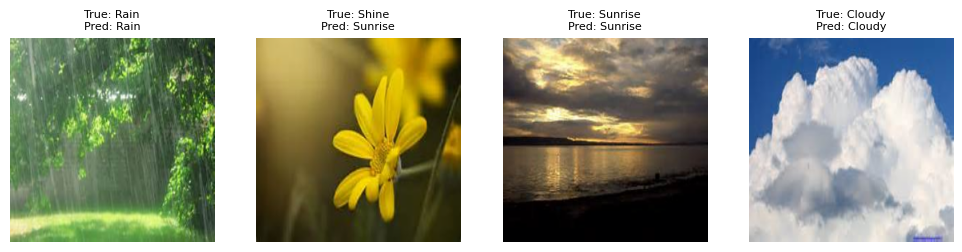

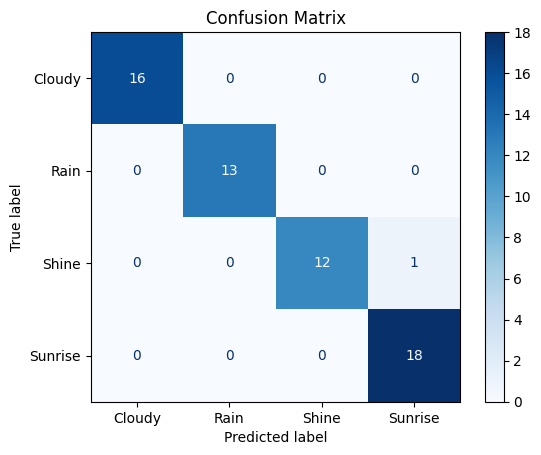

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

# Function to evaluate the model
def evaluate_model(model, test_loader, class_names):

    model.eval()
    running_corrects = 0  # Count correct predictions
    all_preds, all_labels, all_images = [], [], []  # Store predictions, labels, and images for analysis

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Count correct predictions
            running_corrects += torch.sum(preds == labels)

            # Collect data for further analysis
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(inputs.cpu().numpy())


    accuracy = (running_corrects.double() / len(test_loader.dataset)) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

    return accuracy, all_preds, all_labels, all_images

# Function to visualize sample predictions
def show_sample_predictions(images, true_labels, pred_labels, class_names, num_images=4):
    """
    Display a handful of images with their original labels and predicted labels.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2.5))
    for i, ax in enumerate(axes):
        img = images[i].transpose(1, 2, 0)  # Convert CHW to HWC format
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # De-normalize the image
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}", fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Evaluate the model on the test set
test_accuracy, test_preds, test_labels, test_images = evaluate_model(model, test_loader, train_dataset.classes)

# Display 4 random sample predictions
random_indices = random.sample(range(len(test_images)), 4)
selected_images = [test_images[i] for i in random_indices]
selected_true = [test_labels[i] for i in random_indices]
selected_pred = [test_preds[i] for i in random_indices]

show_sample_predictions(selected_images, selected_true, selected_pred, train_dataset.classes, num_images=4)

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



Here we Plot the training and validation accuracy as well as the loss function values as a function to the number of epochs:

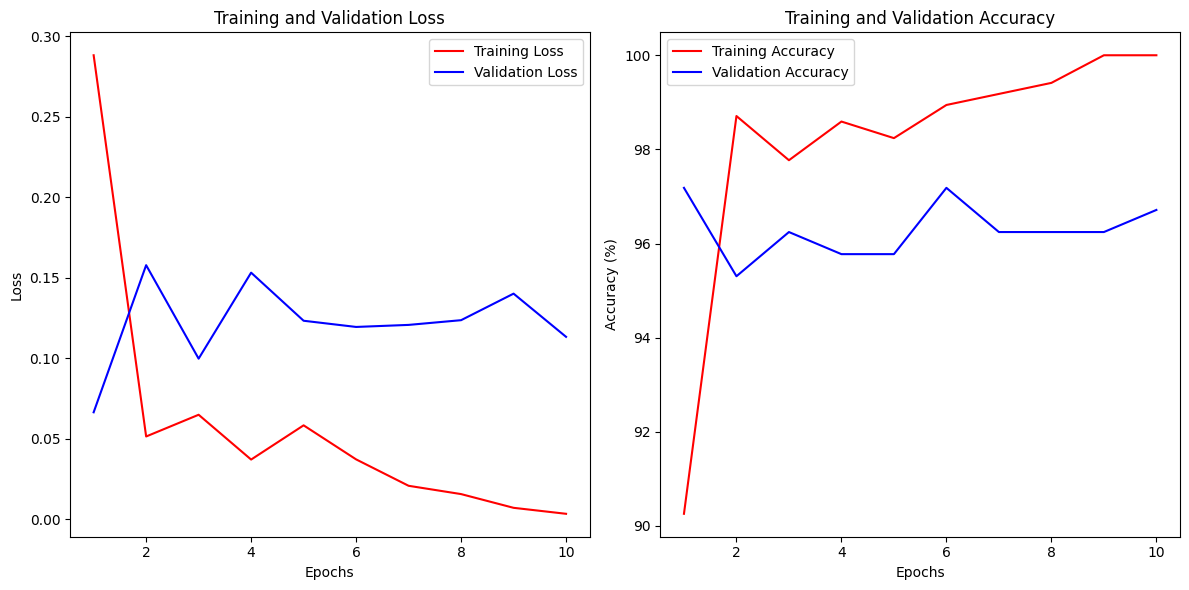

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    # Plot training and validation losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Training Loss')
    plt.plot(epochs, val_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)


Here we use TSNE projection algorithm to visualize how the model classied the data on a 2D plane:


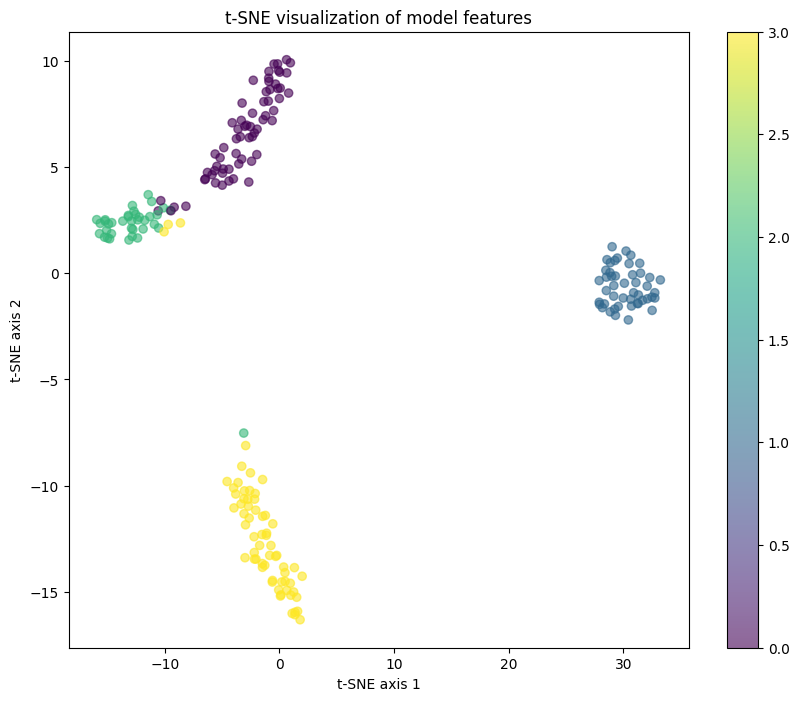

In [ ]:
from sklearn.manifold import TSNE
# Feature extraction
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])  # Remove last layer

    def forward(self, x):
        x = self.features(x)
        x = x.flatten(start_dim=1)
        return x

feature_extractor = FeatureExtractor(model).to(device)

def extract_features(data_loader, model):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

features, labels = extract_features(val_loader, feature_extractor)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_reduced = tsne.fit_transform(features)

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_reduced[:, 0], features_reduced[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE visualization of model features')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.show()

Now we print the model we use, showing the layer details and the
total number of parameters:

In [ ]:
def summarize_model_with_layers(model):

    # Print the model structure (layers only)
    print("Model Structure (Layers):")
    for name, layer in model.named_children():
        print(f"{name}: {layer.__class__.__name__}")
    print("\n")

    # Calculate total number of parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total Parameters: {total_params:,}")

# Example usage
summarize_model_with_layers(model)

Model Structure (Layers):
conv1: Conv2d
bn1: BatchNorm2d
relu: ReLU
maxpool: MaxPool2d
layer1: Sequential
layer2: Sequential
layer3: Sequential
layer4: Sequential
avgpool: AdaptiveAvgPool2d
fc: Sequential


Total Parameters: 11,178,564
